# Overview

For my first go at the NLP Getting Started competition, I tried the "biterm topic model" of [Yan et al 2013](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.402.4032&rep=rep1&type=pdf), thinking that the short length of tweets would lead to a very sparse doc-term matrix and make topic inference sketchy. The biterm model adjusts the Latent Dirichlet topic model in two ways:

* Estimates a single distribution over topics for the whole corpus, instead of estimating a dirichlet prior for that distribution s.t. it can vary over documents, and

* Models the likelihood of biterms -- word pairs co-occurring in documents -- rather than unigrams. This means that although the document-level structure of the topic distribution is gone, it is implicitly reintroduced through this co-occurrence structure

This method gave a basic level of performance (f1 ~.70) but was very slow to run on the full (small!) training set. More traditional classification approaches (e.g. [SVM](https://www.kaggle.com/amackcrane/svm-knn)) turned out to be quicker and better for this task -- which makes sense, because predicting "real or not" labels is not obviously about topic inference per se.

In [1]:
!pip install biterm

  Using cached biterm-0.1.5.tar.gz (79 kB)
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.28-py2.py3-none-any.whl (983 kB)
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [240 lines of output]
      /Users/racheltans/miniforge3/lib/python3.9/site-packages/setuptools/installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
        warnings.warn(
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.0-arm64-3.9
      creating build/lib.macosx-11.0-arm64-3.9/biterm
      copying biterm/btm.py -> build/lib.macosx-11.0-arm64-3.9/biterm
      copying biterm/utility.py -> build/lib.macosx-11.0-arm64-3.9/biterm
      copying biterm/__init__.py -> build/lib.macosx-11.0-arm64-3.9/biterm
      copying b

Failed to build biterm
  Running setup.py install for biterm ... done
  DEPRECATION: biterm was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [2]:
from biterm.cbtm import oBTM
import biterm.utility
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import functools
import math

import matplotlib.pyplot as plt
%matplotlib inline

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

# Wrap 'biterm' for Scikit

In [3]:
class BitermModel(BaseEstimator, TransformerMixin):
    """in: array of string docs
    out: doc-topic matrix"""
    def __init__(self, full=False, n_topics=20, it=50, chunk=100,
                max_df=.1, min_df=2, strip_accents='unicode'):
        # Vectorizer
        self.max_df = max_df
        self.min_df = min_df
        self.strip_accents = strip_accents
        
        # BTM
        self.full = full # False, or float \in (0,1]
        self.chunk = chunk
        self.it = it
        self.n_topics = n_topics

    def fit(self, X, y=None):
        # Vectorize
        self.vectorizer = CountVectorizer(max_df=self.max_df, min_df=self.min_df,
                                          strip_accents=self.strip_accents)
        # get document-word matrix
        self.doc_word = self.vectorizer.fit_transform(X)
        self.doc_word = self.doc_word.toarray()
        # translate doc-word matrix to biterms?
        biterms = biterm.utility.vec_to_biterms(self.doc_word)
        vocab = self.vectorizer.get_feature_names()

        # initialize biterm topic model
        self.btm = oBTM(num_topics=self.n_topics, V=vocab)
        
        # train online, or on a single chunk for quickness
        if self.full:
            end = round(self.full * len(biterms))
            print(str(math.ceil(float(end) / self.chunk)) + " iterations:")
            for i in range(0, end, self.chunk):
                fit_biterms = biterms[i:i+self.chunk]
                self.btm.fit(fit_biterms, iterations=self.it)
        else:
            indices = range(len(biterms))
            biterm_fit_ind = np.random.choice(indices, size=self.chunk, replace=False)
            fit_biterms = [biterms[i] for i in biterm_fit_ind]
            self.btm.fit(fit_biterms, iterations=self.it)
            
        return self

    def transform(self, X):
        # don't save doc_word this time -- it should correspond to the fitting...
        doc_word = self.vectorizer.transform(X)
        doc_word = doc_word.toarray()
        biterms = biterm.utility.vec_to_biterms(doc_word)
        
        self.doc_topic = self.btm.transform(biterms)
        # set 'nan' docs to zero for now
        self.doc_topic = np.where(np.isnan(self.doc_topic), 0, self.doc_topic)
        return self.doc_topic

# Parameters

In [4]:
# baseline parameters
vectorizer_args = {'topicmodel__max_df': .1, 'topicmodel__min_df': 2,
                    'topicmodel__strip_accents': 'unicode'}
# topicmodel__full should be False or a float in (0,1]
topic_args = {'topicmodel__it': 50, 'topicmodel__full': 1,
              'topicmodel__n_topics': 100}
baseline_args = dict(vectorizer_args, **topic_args)

# GridSearch parameters
param_grid = [{'topicmodel__it': [10, 20, 50]},
              {'topicmodel__full': [.05, .1, .3]},
              {'topicmodel__n_topics': [10, 20, 50]}]
gridsearch_params = {'refit': True, 'cv': 3, 'verbose': 0}

# quick formatting test
param_grid = {'topicmodel__it': [10], 'topicmodel__full': [.05],
             'topicmodel__n_topics': [10]}


In [5]:
pipe = Pipeline([('topicmodel', BitermModel()),
                 ('classifier', KNeighborsClassifier())], verbose=False)
pipe.set_params(**baseline_args)

Pipeline(memory=None,
         steps=[('topicmodel',
                 BitermModel(chunk=100, full=1, it=50, max_df=0.1, min_df=2,
                             n_topics=100, strip_accents='unicode')),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

# Train Data 

In [6]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
# shuffle in case we train on a non-random subset
train = train.sample(frac=1, replace=False)
train.shape

(7613, 5)

In [7]:
train.head(5)

,id,keyword,location,text,target
7107,10183,violent%20storm,??? ???? ?f glory. ?,@Skarletan åÇ the storm. A violent swell of em...,0
6369,9101,suicide%20bomb,Nigeria,Pic of 16yr old PKK suicide bomber who detonat...,1
6696,9593,thunder,"Palma, Islas Baleares",@AsimTanvir @NemesisK_PES @KevR_7 Snow? Thund...,1
3091,4437,electrocute,"Budapest, Hungary",Photo: weallheartonedirection: I wouldnÛªt le...,0
4316,6128,hellfire,"Denver, Colorado",@MechaMacGyver Wow bet you got blamed for that...,0


In [8]:
train['length'] = list(map(lambda x: len(x.split()), train.text))
# print(train.length.describe())
# print(train.target.astype('category').describe())
# print(train.keyword.astype('category').describe())
# print(train.keyword.value_counts()[:20])

In [9]:
labels = np.array(train.target)
labels.shape


(7613,)

### Word Frequency Dist.

  0%|          | 0/1 [00:00<?, ?it/s]

1 iterations:


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


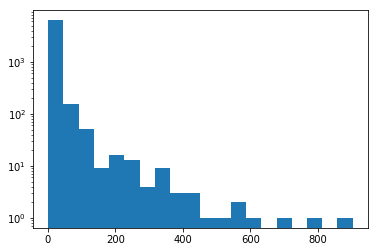

In [10]:
check = BitermModel(full=.01, it=1).fit(train.text)
doc_word = check.doc_word
frequencies = np.add.reduce(doc_word, axis=0)
plt.hist(frequencies, bins=20, log=True)
#plt.title("Distribution of Word Frequencies")
pass

# Grid Search

In [11]:
if isinstance(param_grid, list):
    nrows = len(param_grid)
else:
    nrows=1
    param_grid = [param_grid]

best_params = []
results = []
for i in range(nrows):
    gridsearch = GridSearchCV(pipe, param_grid=param_grid[i],
                             **gridsearch_params)
    gridsearch.fit(X=train.text, y=labels)
    results.append(pd.DataFrame(gridsearch.cv_results_))
    best_params.append(gridsearch.best_params_)

    # reset
    pipe.set_params(**baseline_args)

  0%|          | 0/10 [00:00<?, ?it/s]

3 iterations:


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/10 [00:00<?, ?it/s]

3 iterations:


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/10 [00:00<?, ?it/s]

3 iterations:


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
  0%|          | 0/10 [00:00<?, ?it/s]

4 iterations:


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [12]:
#for res in results:
#    print(res.filter(items=['params', 'mean_fit_time', 
#                            'mean_test_score']))

# Results

In [13]:
for i,res in enumerate(results):
    # pull out params_ columns...
    params = res.filter(like='param_')

    # how many params are there?
    cols = params.shape[1]

    if cols == 1:
        fig, ax = plt.subplots()
        xlims = [params.values.min(), params.values.max()]
        ylims = [res.mean_test_score.values.min(), 
                res.mean_test_score.values.max()]
        ax.plot(params, res.mean_test_score, 'b-', label="Test Score")
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_xlabel(params.columns[0])

        ax2 = ax.twinx()
        ax2.plot(params, res.mean_fit_time, 'r-', label="Fit Time")

        ax.set_ylabel("Score")
        ax2.set_ylabel("Time (s)")
        fig.legend()
    else:
        table = res.pivot_table(columns=params.columns[0], 
                              index=params.columns[1],
                              values=['mean_test_score', 'mean_fit_time',
                                     'rank_test_score'])
        print(table)
        #axs[i].axis('off')
        #axs[i].table(cellText=table.values, rowLabels=table.index, 
        #             colLabels=table.columns, loc=9)



                       mean_fit_time mean_test_score rank_test_score
param_topicmodel__full          0.05            0.05            0.05
param_topicmodel__it                                                
10                         36.619302        0.606068               1


# Refit

in case we did separate cross-validations for different params

In [14]:
new_params = functools.reduce(lambda x,y: dict(x, **y), best_params, {})
pipe.set_params(**new_params)
pipe.fit(X=train.text, y=labels)
pass

  0%|          | 0/10 [00:00<?, ?it/s]

4 iterations:


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


# Inspect Features

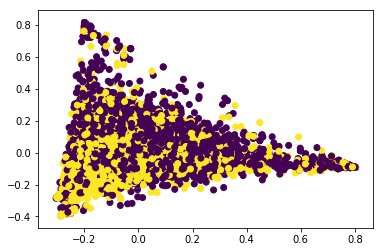

In [15]:
doc_topic = pipe['topicmodel'].doc_topic
pca = PCA(n_components=2)
doc_pc = pca.fit_transform(doc_topic)
doc_pc.shape
plt.scatter(x=doc_pc[:,0], y=doc_pc[:,1], c=labels)
pass

# Submission

In [16]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
print(test.shape)
test_labels = pipe.predict(test.text)
print(test_labels.shape)

(3263, 4)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


(3263,)


In [18]:
submission = pd.DataFrame({'id': test.id, 'target': test_labels})
submission.to_csv('submission.csv', index=False)
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1
